# What would you find in this project?

The purpose of this project is to deal with a **real world classification problem and approach it with a business concern**: from explaining the insights we can get just from the data, find a ML model that would fit on the classification problem and finally put into production the model and the insights we can get from it.

For this project I've chosen this Kaggle dataset: [HR Analytics: Job Change of Data Scientists](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists/data). This dataset contains personal information of the employees of different companies and the purpose is to predict which employees wants to leave the company. This is a real business concern because the cost of losing an employee can range from [100% to 150% of the salary for technical positions](https://builtin.com/recruiting/cost-of-turnover), so the objective is to **predict in advance which employees have more probability to leave the company** for being able to take actions in order to reduce the leaving cost.

# Exploratory Data Analysis

## Import data

First of all, we'll import (and install) all necessary libraries we'll need in this notebook.

In [1]:
#pip install xgboost
#pip install pycaret
#pip install catboost
#pip install lightgbm
#pip install tensorflow
#pip install keras
#pip install scikeras
#pip install imbalanced-learn==0.11.0 
#pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras import backend as K
from imblearn.over_sampling import SMOTE
import shap
import pickle
import warnings
warnings.filterwarnings('ignore') #For a cleaner lecture
%matplotlib inline

Now, we can import the data and take a look to the first rows:

In [2]:
df = pd.read_csv('aug_train.csv')
df.head(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


Let's take a look to the features of our dataset, the type of each features inferred from pandas and the count of not null values:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

As we can see above we have a dataset with 19158 rows and 14 columns. Here you can see a description of each feature, get from the kaggle dataset:

- **enrollee_id**: Unique ID for candidate
- **city**: City code
- **city_development_index** : Developement index of the city (scaled)
- **gender**: Gender of candidate
- **relevent_experience**: Relevant experience of candidate
- **enrolled_university**: Type of University course enrolled if any
- **education_level**: Education level of candidate
- **major_discipline**: Education major discipline of candidate
- **experience**: Candidate total experience in years
- **company_size**: No of employees in current employer's company
- **company_type**: Type of current employer
- **last_new_job**: Difference in years between previous job and current job
- **training_hours**: training hours completed
- **target**: 0 – Not looking for job change, 1 – Looking for a job change

Our target binary variable has been detected as a float feature, so manually we can set it as a category feature as this:

In [4]:
df['target'] = df['target'].astype(object)

Another important thing is to check how many null data we have on the dataset. In case we only have a few nulls or to much nulls, we just can delete those records/feature, but otherwise we'll have to infer the missing data. Here you can see all the features with the total on null values:

In [5]:
df.isna().sum().sort_values(ascending = False)

company_type              6140
company_size              5938
gender                    4508
major_discipline          2813
education_level            460
last_new_job               423
enrolled_university        386
experience                  65
enrollee_id                  0
city                         0
city_development_index       0
relevent_experience          0
training_hours               0
target                       0
dtype: int64

If there would have been a feature with a lot of nulls, we should have removed it from our data, as the following:
df.drop(columns = ['column_name'], inplace = True). This is not the case, so we're going to try to input the missing values.

## Exploratory Data Analysis for categorical features

Let's plot all the category features using a barplot. We'll see all the values of each feature and its frequency. In addition, we'll plot the null values as "No Data" as well, in order to observe the weight of the null values in each feature.

In [6]:
def charts_categorical_features(cat):
    from math import ceil
    rows = ceil(cat.shape[1] / 2)

    #Define the space where we'll print all the graphs
    f, ax = plt.subplots(nrows = rows, ncols = 2, figsize = (30, rows*10))

    ax = ax.flat
    for graph, feauture in enumerate(cat):
          cat[feauture].value_counts().plot.barh(ax = ax[graph])
          ax[graph].set_title(feauture, fontsize = 20, fontweight = "bold")
          ax[graph].tick_params(labelsize = 17)
          ax[graph].bar_label(ax[graph].containers[0])


In [7]:
df_eda = df.copy()
# Don't show a graphic if the feature have more than this param unique values
treeshold_graphics_cardinal_categorical_features = 20 
features_unique_values = df_eda.nunique()
features_unique_values_less_than_value = features_unique_values[features_unique_values < treeshold_graphics_cardinal_categorical_features].index
# In order to see how many nulls there are in each feature we'll also print them in the following charts as "No data" value.
for feature in features_unique_values_less_than_value:
  df_eda[feature].fillna("No Data", inplace = True)

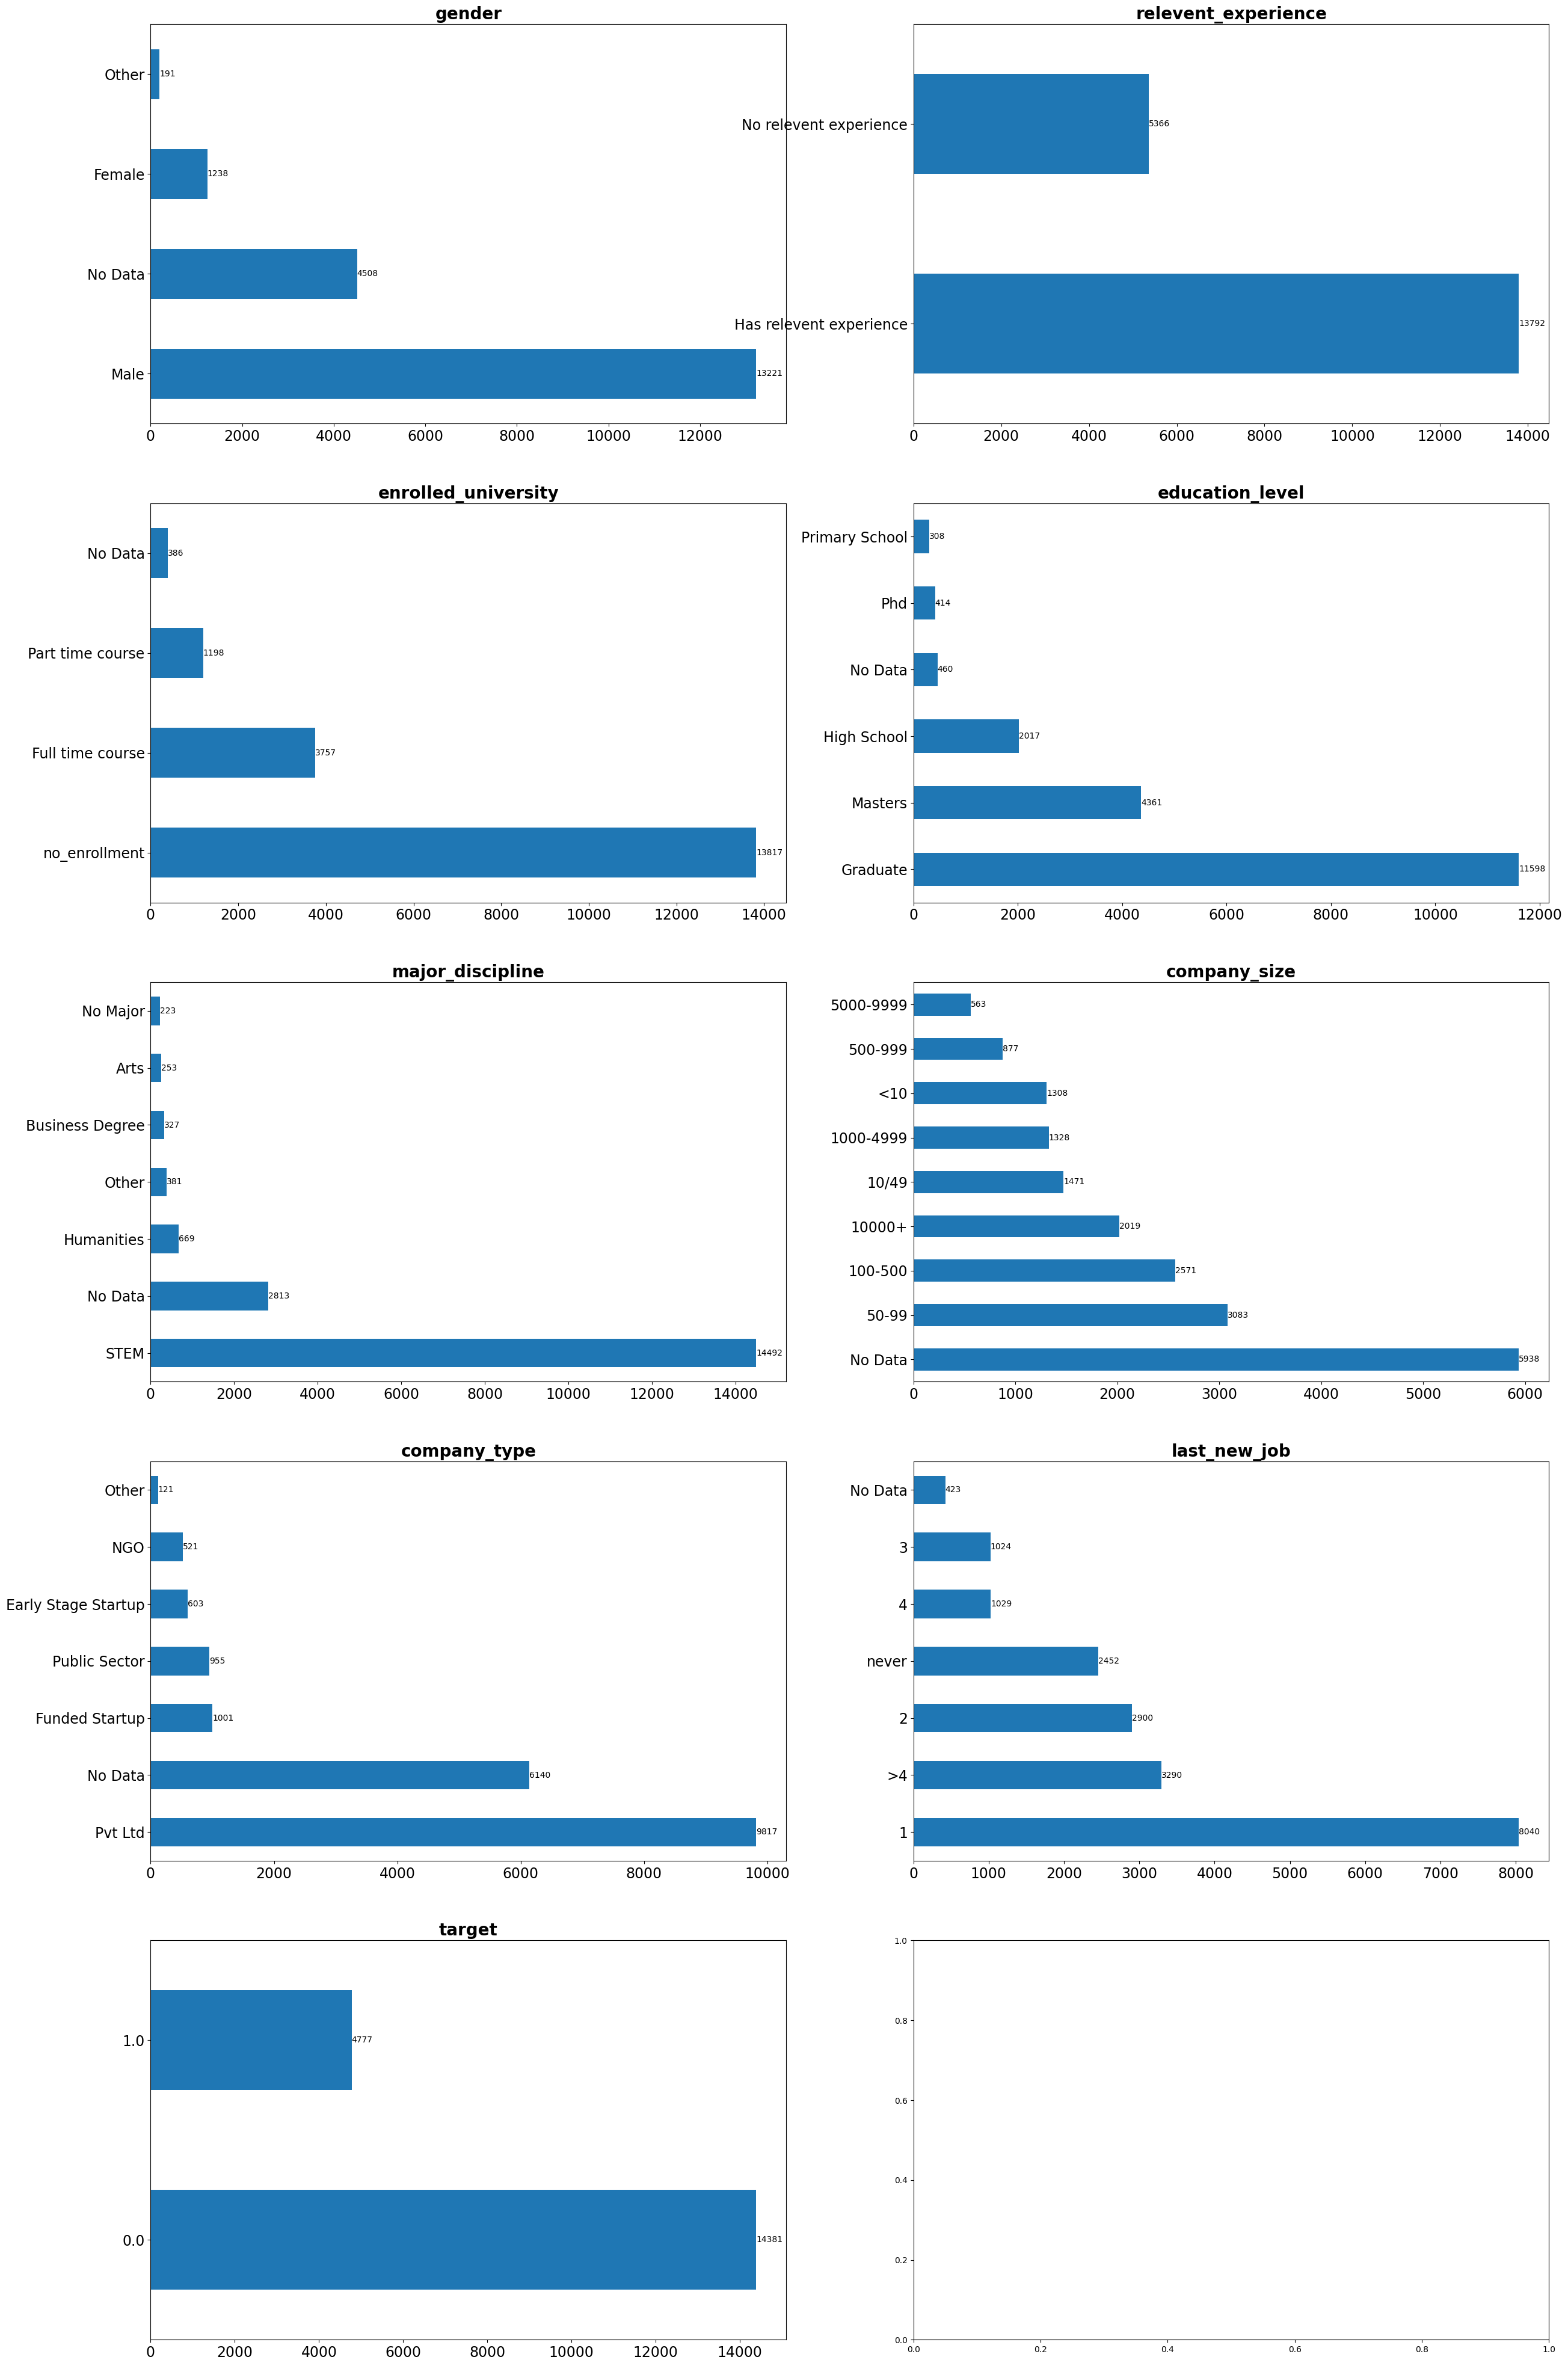

In [8]:
charts_categorical_features(df_eda[features_unique_values_less_than_value].select_dtypes('O'))

In order to create understandable charts, we'll remove those features with a lot a unique values (as city and enrollee id). Also, we've printed the null values as "No data" in order to see in an easy way which percentage of the feature represents the null data.

So, from the above charts we can say the following:
1. We have an **imbalanced dataset** because the binary target feature doesn't have a 50% of occurrences in each value.
2. The majority of the employees are: men, they have relevant experience, currently they aren't enrolled in the university but they have a degree education level. The majority has been educated in science, technology, engineering or math (STEM) and they work for a private company around 50-99 employees. Finally, the majority has a seniority of 1 year in their actual job, which is not a lot.
3. It's curious that for the feature company size we have more **null values** than any other value and in the gender feature we have more null values than females. Also, for company size the "No data" value is the second one with more records. In case we had the chance to get the source data, we could examine why there are so many nulls in these categories and if there is a chance to fill those null values from the source.
4. It's curious that being a data scientist dataset we can see education levels as primary or high school and educational fields outside STEM careers as: humanities and arts.

## Exporatory Data Analysis for continious variable

As we've done before, let's see the histogram of the continous variables:

In [9]:
def charts_numerical_features(num):
    from math import ceil
    filas = ceil(num.shape[1] / 2)

    #Define the space where we'll print all the graphs
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    ax = ax.flat
    for graph, feature in enumerate(num):
        sns.histplot(num[feature], color="blue",ax = ax[graph])
        ax[graph].set_title("Distributional of " + feature)

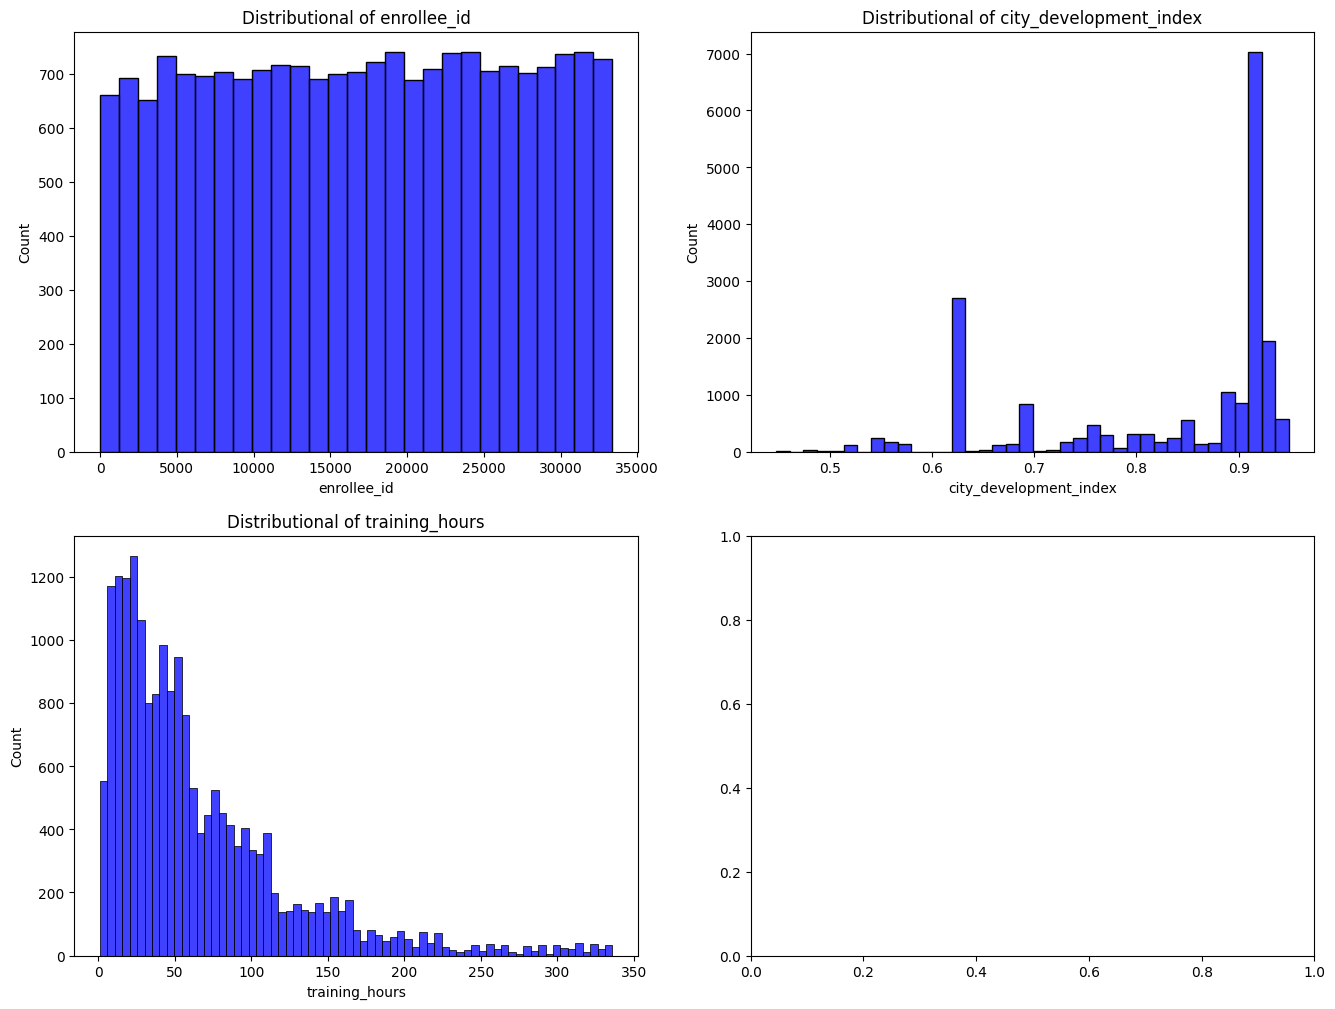

In [10]:
charts_numerical_features(df.select_dtypes('number'))

As we can see above, the majortiy of the employees of this dataset leaves in a city with a high development index (also the maximum peak is greater than 0.9). but also there is a considerable number of employees who live in a city with a development index arround 0.62-0.64 (the second higher peak). 

Adding to this information, the main stadistics metrics:

In [11]:
df.describe()

,enrollee_id,city_development_index,training_hours
count,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896
std,9616.292592,0.123362,60.058462
min,1.000000,0.448000,1.000000
25%,8554.250000,0.740000,23.000000
50%,16982.500000,0.903000,47.000000
75%,25169.750000,0.920000,88.000000
max,33380.000000,0.949000,336.000000


We also can say that a 50% of the employees have between 23 and 88 hours of trainning.

Let's check the correlation between the numeric features:

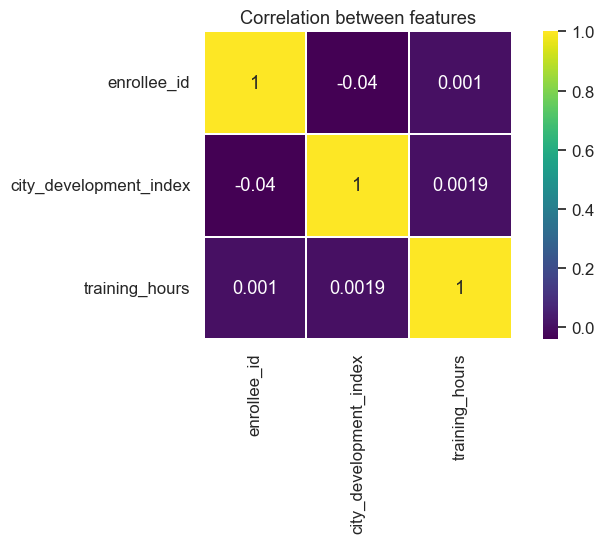

In [12]:
corrMatrix=df_eda.corr(numeric_only=True)

sns.set(font_scale=1.10)
plt.figure(figsize=(8, 4))

sns.heatmap(corrMatrix,  linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features');

It's not seems to be any correlation between these three numeric features.

### Seed questions to understand better the data and its peculiarities

#### **Which percentage of the persons wants to search for a new position?**




In [13]:
df.groupby(['target'])['target'].count()/len(df)*100

target
0.0    75.065247
1.0    24.934753
Name: target, dtype: float64

**The 24,93% of candidates search for a new position** (so is an imbalaced dataset)

#### **Which are the characteristics of the persons who wants to search for a new position?**
We'll use this function to get this information

In [14]:
def perc_total_and_relative_target_per_feature(dataframe, feature, target_value):
  print("Total amount of positive target feature for each value of the feature " + feature + ":\n")
  print(dataframe[dataframe.target == target_value].groupby([feature])[feature].count())
  print("\nTotal positive target values:\n")
  print(len(dataframe[dataframe.target == target_value]))
  print("\nThe percentage of positive target feature of each value for the feature " + feature + " over the total positive target feature:\n")
  print(dataframe[dataframe.target == target_value].groupby([feature])[feature].count()/len(dataframe[dataframe.target == target_value])*100)
  print("\nThe percentage of positive target value per labels for the feature " + feature + " over the count of each respespective value for the feature over all the dataset:\n")
  print(dataframe[dataframe.target == target_value].groupby([feature])[feature].count()/dataframe.groupby([feature])[feature].count()*100)

##### _By gender_

In [15]:
perc_total_and_relative_target_per_feature(df_eda,"gender",1)

Total amount of positive target feature for each value of the feature gender:

gender
Female      326
Male       3012
No Data    1389
Other        50
Name: gender, dtype: int64

Total positive target values:

4777

The percentage of positive target feature of each value for the feature gender over the total positive target feature:

gender
Female      6.824367
Male       63.052125
No Data    29.076826
Other       1.046682
Name: gender, dtype: float64

The percentage of positive target value per labels for the feature gender over the count of each respespective value for the feature over all the dataset:

gender
Female     26.332795
Male       22.781938
No Data    30.811890
Other      26.178010
Name: gender, dtype: float64


The 63% of employees that are seeking for a new position are men, but this is pretty understandable because Male is the major value of the feature gender. Also, **the 26% of the females are seeking for a new position, and only the 22% of the males are seeking for a new position**, so in proportion the females are seeking for a new position more than the males, even there's no huge difference between them. Other gender has the same analysis than female. It is noticeable that, in proportion, where we have **the most percentage of employees seeking for a new job (30%) is when we don't have data on the gender**. This information also can we summarized in the following chart:

<AxesSubplot: xlabel='gender', ylabel='count'>

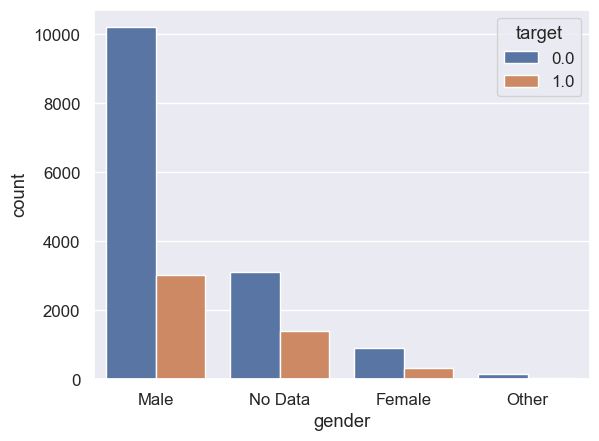

In [16]:
sns.countplot(df_eda, x="gender", hue="target")

##### _By Relevent experience_

In [17]:
perc_total_and_relative_target_per_feature(df_eda,"relevent_experience",1)

Total amount of positive target feature for each value of the feature relevent_experience:

relevent_experience
Has relevent experience    2961
No relevent experience     1816
Name: relevent_experience, dtype: int64

Total positive target values:

4777

The percentage of positive target feature of each value for the feature relevent_experience over the total positive target feature:

relevent_experience
Has relevent experience    61.984509
No relevent experience     38.015491
Name: relevent_experience, dtype: float64

The percentage of positive target value per labels for the feature relevent_experience over the count of each respespective value for the feature over all the dataset:

relevent_experience
Has relevent experience    21.468968
No relevent experience     33.842713
Name: relevent_experience, dtype: float64


As we've seen in the gender analysis, here there is a majority value for the feature revelent_esperience, which is the employee have relevant experience, so also the 61%  of employees that are seeking for a new position also has a relevant experience, but in proportion, the **33% of the persons with no experience are seeking for a new job**, in contrast to the 21% of the persons with experience that are seeking for a new job. This also can be seen in the following chart:

<AxesSubplot: xlabel='relevent_experience', ylabel='count'>

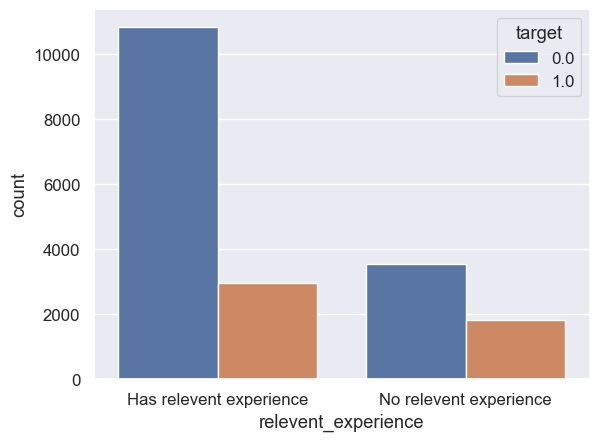

In [18]:
sns.countplot(df_eda, x="relevent_experience", hue="target")

##### _By Education level_       

In [19]:
perc_total_and_relative_target_per_feature(df,"education_level",1)

Total amount of positive target feature for each value of the feature education_level:

education_level
Graduate          3245
High School        394
Masters            935
Phd                 58
Primary School      41
Name: education_level, dtype: int64

Total positive target values:

4777

The percentage of positive target feature of each value for the feature education_level over the total positive target feature:

education_level
Graduate          67.929663
High School        8.247854
Masters           19.572954
Phd                1.214151
Primary School     0.858279
Name: education_level, dtype: float64

The percentage of positive target value per labels for the feature education_level over the count of each respespective value for the feature over all the dataset:

education_level
Graduate          27.978962
High School       19.533961
Masters           21.440037
Phd               14.009662
Primary School    13.311688
Name: education_level, dtype: float64


As can see above, the 67% of the people seeking for new position has a graduate education level. Because graduate is the majority class is understandable that also is the majority of the positive class, but it is also the class with major respective percentage, which is, the **27.98% of the people with graduate education are seeking for a new position**. It's interesting to see that there's no a direct proportion between the level of study and the percentage of people searching for a new position. That is, with the greatest or with the lowest graduation level we don't have also the greatest or the lowest percentage of people seeking for a new position, for example the lowest respective percentages are phd and primary school, which both are the opposite educational levels.

That also could be because for PHD and primary we have lower amounts of records and could no be representative at all.

This also can be seen in the following chart:

<AxesSubplot: xlabel='education_level', ylabel='count'>

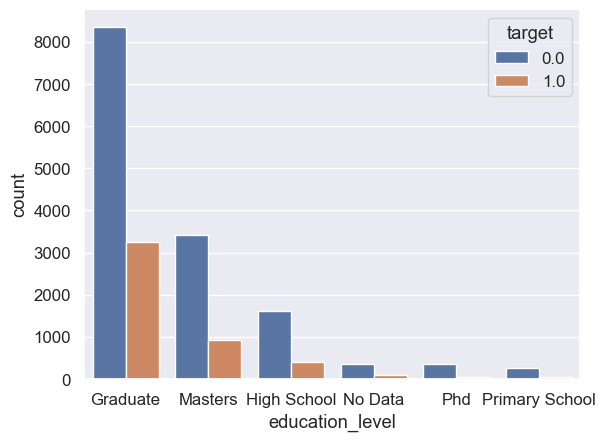

In [20]:
sns.countplot(df_eda, x="education_level", hue="target")

##### _By Experience_                 

In [21]:
perc_total_and_relative_target_per_feature(df,"experience",1)

Total amount of positive target feature for each value of the feature experience:

experience
1      233
10     207
11     151
12      92
13      77
14     107
15     114
16      72
17      57
18      43
19      53
2      374
20      33
3      478
4      457
5      412
6      343
7      303
8      195
9      213
<1     237
>20    503
Name: experience, dtype: int64

Total positive target values:

4777

The percentage of positive target feature of each value for the feature experience over the total positive target feature:

experience
1       4.877538
10      4.333264
11      3.160980
12      1.925895
13      1.611890
14      2.239900
15      2.386435
16      1.507222
17      1.193218
18      0.900147
19      1.109483
2       7.829181
20      0.690810
3      10.006280
4       9.566674
5       8.624660
6       7.180239
7       6.342893
8       4.082060
9       4.458865
<1      4.961273
>20    10.529621
Name: experience, dtype: float64

The percentage of positive target value per labels f

As we can see above, around the **42-45% of the people with equal or less than 1 year of experience are seeking for a new position**, opposed to that, people with more experience (>11 years) this percentage falls to < 20%. In general, it's seems that there is an inverse correlation, with the lower years of experience, the percentage is higher and the higher years of experience, the percentage is lower.

##### _By training hours_

We'll use a boxplot to see if we see any differences between those employees who are seeking for a new position and who do not, taking into account the training hours.

<AxesSubplot: xlabel='target', ylabel='training_hours'>

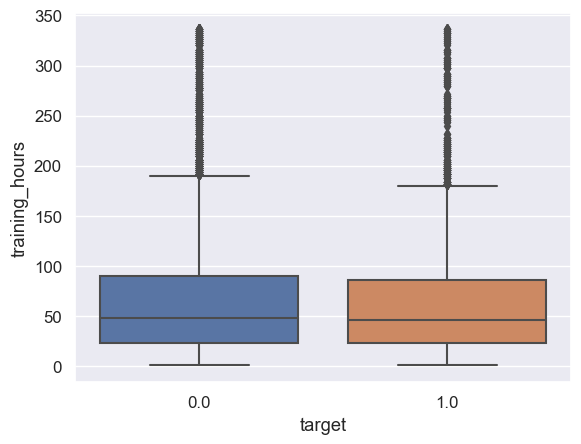

In [22]:
sns.boxplot(data=df_eda, y="training_hours", x="target")

We can't appreciate any difference between them to be emphasised.

##### _By city development index_

<AxesSubplot: xlabel='target', ylabel='city_development_index'>

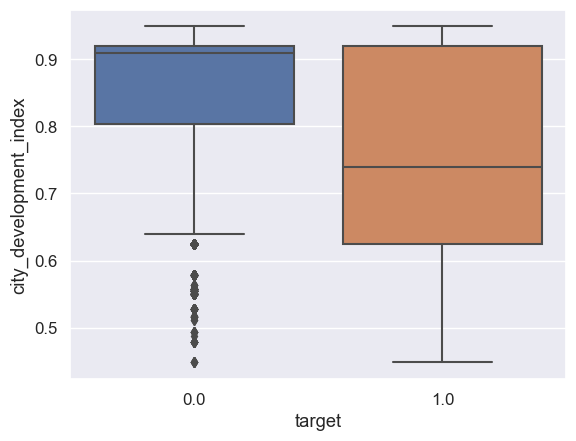

In [23]:
sns.boxplot(data=df_eda, y="city_development_index", x="target")

That it's interesting, because here we can see that for those employees that aren't seeking for a new job, they live in cities with greater development index: the "minimum" index (for the bloxplot) of those who aren't searching a new position is similar for the Q1 quantile of those who are searching for a new position, also medians are quite different. **It's seems to be that those employees who live in a city with a lower city development index are more sensitive for seeking for a new job.**

## Summary of bussiness analytics

About the full dataset we, can say:
- The majority of the employees are: men, they have relevant experience, currently they aren't enrolled in the university but they have a degree education level. The majority has been educated in science, technology, engineering or math (STEM) and they work for a private company around 50-99 employees. Finally, the majority has a seniority of 1 year in their actual job, which is not a lot.
- There are a **few features with a lot of null values** as: gender, major discipline, company size, company type.In case we had the chance to get the source data, we could examine why there are so many nulls in these categories and if there is a chance to fill those null values.

About the employees that are seeking for a new position, we can say:
- The **24,93% of employes search for a new position**.
- The 26% of the females are seeking for a new position, and only the 22% of the males are seeking for a new position (same for other gender). For those employees we don't have any information about their gender, about a 30% are seeking for a new position.
- With the greatest or with the lowest graduation level we don't have also the greatest or the lowest percentage of people seeking for a new position, for example the lowest respective percentages are phd and primary school, which both are the opposite educational levels.
- The 27.98% of the people with **graduate education** are seeking for a new position.
- The 42-45% of the people with **equal or less than 1 year of experience** are seeking for a new position
- It's seems to be that those employees who live in a city with a lower **city development index is more sensitive for seeking for a new job**.



# Machine Learning

## Transform categorical variables to numerical


There are ml algorithms that only work with numerical data, for that reason we need to transform our category features into numerical features. We'll use numerical imputation with ordinal features, where exist an order in the possible values of the feature, for example ratings, size classifications, educational levels, etc. For nominal variables we'll use one hot encoding. For more info [here](https://medium.com/@brandon93.w/converting-categorical-data-into-numerical-form-a-practical-guide-for-data-science-99fdf42d0e10).

### Ordinal features
The ordinal features that we'll map each value to a number are the following: education_level, experience, company_size,  last_new_job


In [24]:
# Making Dictionaries of ordinal features
education_level_map = {
    'Primary School' :    0,
    'High School'    :    1,
    'Graduate'       :    2,
    'Masters'        :    3,
    'Phd'            :    4
    }

experience_map = {
    '<1'      :    0,
    '1'       :    1,
    '2'       :    2,
    '3'       :    3,
    '4'       :    4,
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8,
    '9'       :    9,
    '10'      :    10,
    '11'      :    11,
    '12'      :    12,
    '13'      :    13,
    '14'      :    14,
    '15'      :    15,
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19,
    '20'      :    20,
    '>20'     :    21
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1,
    '100-500'      :    2,
    '1000-4999'    :    3,
    '10000+'       :    4,
    '50-99'        :    5,
    '500-999'      :    6,
    '5000-9999'    :    7
}

last_new_job_map = {
    'never'        :    0,
    '1'            :    1,
    '2'            :    2,
    '3'            :    3,
    '4'            :    4,
    '>4'           :    5
}

In [25]:
# Transforming Categorical features into numarical features
df_numerical = df.copy()
df_numerical.loc[:,'education_level'] = df_numerical['education_level'].map(education_level_map)
df_numerical.loc[:,'company_size'] = df_numerical['company_size'].map(company_size_map)
df_numerical.loc[:,'last_new_job'] = df_numerical['last_new_job'].map(last_new_job_map)
df_numerical.loc[:,'experience'] = df_numerical['experience'].map(experience_map)

In [26]:
df_numerical.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,2.0,STEM,21.0,NaN,NaN,1.0,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,2.0,STEM,15.0,5.0,Pvt Ltd,5.0,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,2.0,STEM,5.0,NaN,NaN,0.0,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,2.0,Business Degree,0.0,NaN,Pvt Ltd,0.0,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,3.0,STEM,21.0,5.0,Funded Startup,4.0,8,0.0


### Nominal features

The nominal features are: city, gender, relevent_experience, enrolled_university, major_discipline and company_type but it seems there's a 1:1 relation between city and city_development_index. Let's find out:

In [27]:
(df.groupby(['city'])['city_development_index'].max() == df.groupby(['city'])['city_development_index'].min()).all()

True

There's a 1:1 relation between de city and city_development_index, so let's **discard the feature city** for the model because we have a redudant feature (we'll discard this one because is a category feature).



    

In [28]:
df_numerical = df_numerical.drop('city', axis=1)
df_numerical.head()

,enrollee_id,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,0.920,Male,Has relevent experience,no_enrollment,2.0,STEM,21.0,NaN,NaN,1.0,36,1.0
1,29725,0.776,Male,No relevent experience,no_enrollment,2.0,STEM,15.0,5.0,Pvt Ltd,5.0,47,0.0
2,11561,0.624,NaN,No relevent experience,Full time course,2.0,STEM,5.0,NaN,NaN,0.0,83,0.0
3,33241,0.789,NaN,No relevent experience,NaN,2.0,Business Degree,0.0,NaN,Pvt Ltd,0.0,52,1.0
4,666,0.767,Male,Has relevent experience,no_enrollment,3.0,STEM,21.0,5.0,Funded Startup,4.0,8,0.0


Let's use **dummy encoding** to encode the rest of categorical features: gender, relevent_experience, enrolled_university, major_discipline and company_type. Also, we'll do this type of encoding because these features don't have a high cardinality. To do so, we'll have to impute an 'unknown' value to all null values of these features.

In [29]:
# First of all we input 'unknown' value to the features we want to apply one hot encoding
df_numerical[['gender', 'relevent_experience','enrolled_university','major_discipline','company_type']] = df_numerical[['gender', 'relevent_experience','enrolled_university','major_discipline','company_type']].fillna('unknown')
df_numerical.isna().sum().sort_values(ascending = False)


company_size              5938
education_level            460
last_new_job               423
experience                  65
enrollee_id                  0
city_development_index       0
gender                       0
relevent_experience          0
enrolled_university          0
major_discipline             0
company_type                 0
training_hours               0
target                       0
dtype: int64

Convert to numerical by using dummy encoding:

In [30]:
df_numerical = pd.get_dummies(df_numerical, columns=['gender', 'relevent_experience','enrolled_university','major_discipline','company_type'] )
df_numerical.head()

,enrollee_id,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,gender_Female,gender_Male,...,major_discipline_Other,major_discipline_STEM,major_discipline_unknown,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown
0,8949,0.920,2.0,21.0,NaN,1.0,36,1.0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,29725,0.776,2.0,15.0,5.0,5.0,47,0.0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,11561,0.624,2.0,5.0,NaN,0.0,83,0.0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,33241,0.789,2.0,0.0,NaN,0.0,52,1.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,666,0.767,3.0,21.0,5.0,4.0,8,0.0,0,1,...,0,1,0,0,1,0,0,0,0,0


## Input missing values

Let's refresh how much values we have null:

In [31]:
total_null_values = df_numerical.isna().sum().sort_values(ascending = False)
perc_null_values = round(df_numerical.isna().sum().sort_values(ascending = False)/len(df_numerical)*100,2)
total_null_values = total_null_values.to_frame(name="count_nulls")
perc_null_values = perc_null_values.to_frame(name="perc_null")
df_null_values = pd.concat([total_null_values, perc_null_values], axis=1)
df_null_values

,count_nulls,perc_null
company_size,5938,30.99
education_level,460,2.40
last_new_job,423,2.21
experience,65,0.34
enrollee_id,0,0.00
company_type_Early Stage Startup,0,0.00
major_discipline_Humanities,0,0.00
major_discipline_No Major,0,0.00
major_discipline_Other,0,0.00
major_discipline_STEM,0,0.00


We have 8 features with null values. Because there are libraries like sckitlearn that don't allow null values, let's **input a value to this nulls**. This can be approached by simple methods. For categorical features, we can input the mode and for numerical features, the mean or the median. This time we'll use a ML approach using **K Nearest Neighbours**.

In [32]:
from sklearn.impute import KNNImputer
df_inputed_nulls = df_numerical.copy()
knn_imputer = KNNImputer()
X = knn_imputer.fit_transform(df_inputed_nulls)
df_inputed_nulls = pd.DataFrame(X, columns = df_inputed_nulls.columns)

In [33]:
df_inputed_nulls.head()

,enrollee_id,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,gender_Female,gender_Male,...,major_discipline_Other,major_discipline_STEM,major_discipline_unknown,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown
0,8949.0,0.920,2.0,21.0,4.0,1.0,36.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,29725.0,0.776,2.0,15.0,5.0,5.0,47.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,11561.0,0.624,2.0,5.0,1.4,0.0,83.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33241.0,0.789,2.0,0.0,0.8,0.0,52.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,666.0,0.767,3.0,21.0,5.0,4.0,8.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Check we don't have any null in the dataframe
df_inputed_nulls.isnull().values.any()

False

There's no nulls left and all features are numerical, so we could use this dataset in the case that the model/library we'll try on demands a numerical and non null data.

## Modeling

### Split training and test data

In [35]:
df_numerical_no_nulls = df_inputed_nulls.copy()
df_numerical_no_nulls = df_numerical_no_nulls.drop('enrollee_id', axis=1) # Drop unnecessary column

df_numerical_no_nulls['target'] = df_numerical_no_nulls['target'].astype(int)
X_numerical_no_nulls = df_numerical_no_nulls.dropna().drop(columns=['target']).values
y_numerical_no_nulls = df_numerical_no_nulls.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X_numerical_no_nulls, y_numerical_no_nulls, test_size=0.3, random_state=80)

In [36]:
df_results = pd.DataFrame()  # Here we'll store the performance metrics of each model

#### Compare data in training and test dataset

It's important to check if train and test data are similar in order to guarantee that we can rely on our metrics performance in the test and training set. The goal in every ML problem is being able to generalize with good results the model we've trained with unseen data (the test set). That's why we have to check that training and test data are similar, because otherwise if they are different we can't expect them to have good and similar metrics performance, even the training data has good performance metrics.

First of all, let's compare that in both datasets we have the same proportion of the positive target class:

In [37]:
abs(y_train.mean()-y_test.mean())

0.009134117654384988

As we can see above, the difference between the two proportions are near 0, so we can be sure that for the target feature, the training and the test dataset are similar.

Secondly, compare all the principal statistic metrics for the other features:

In [38]:
df_X_train  = pd.DataFrame(data=X_train, columns=df_numerical_no_nulls.columns.drop('target'))
df_X_test  = pd.DataFrame(data=X_test, columns=df_numerical_no_nulls.columns.drop('target'))
describe_X_train = df_X_train.describe().T
describe_X_test = df_X_test.describe().T
abs(describe_X_train.sub(describe_X_test).iloc[:,1:])  # Substract the metrics for each feature

,mean,std,min,25%,50%,75%,max
city_development_index,0.000879,0.001134,0.0,0.00125,0.007,0.0,0.0
education_level,0.006721,0.013315,0.0,0.00000,0.000,0.8,0.0
experience,0.039588,0.008734,0.0,0.00000,0.000,0.0,0.0
company_size,0.039404,0.001375,0.0,0.00000,0.000,0.2,0.0
last_new_job,0.026455,0.019090,0.0,0.00000,0.000,0.0,0.0
training_hours,0.135189,0.754950,0.0,0.00000,0.000,0.0,0.0
gender_Female,0.006571,0.011777,0.0,0.00000,0.000,0.0,0.0
gender_Male,0.010510,0.004354,0.0,0.00000,0.000,0.0,0.0
gender_Other,0.002064,0.010418,0.0,0.00000,0.000,0.0,0.0
gender_unknown,0.001874,0.001151,0.0,0.00000,0.000,0.0,0.0


The difference between the principals statistic metrics of training and test dataset are near or equally 0, so we can be sure that the training and the test dataset are similar enough to generalize the results of the model in unseen data.

### Performance Metric

We're dealing with an imbalanced binary classification problem, but is not a heavily imbalanced classification. In addition, we'll care for both classes in the same way, ie, let's assume that the two classes have the same weight because of the implications for the company but also for the employee in case we make a mistake in the classification. For these reasons we'll be using **ROC AUC Score**. If it's considered more risky the positive class, then we should use a distinct metric as _PR AUC Score_. For more information [here](https://neptune.ai/blog/evaluation-metrics-binary-classification).

### Models

In this section, we'll try to fit the previous data in a ML model. To do so, we'll use a hyperparameter tuning and a cross validation. 

For processing time reasons, instead of using the usual, gridsearchCV we'll use a faster alternative: the Halving Grid Search (HGS) CV, which does a pretraining with all the combinations of parameters setted in the grid search but with a subset of the data. The top performing models are selected for a training with a larger subset of training data. Also, for the same reason, in the cross validation we'll use 3 folds instead of the usual 5 or 10 folds.

#### **SVM**

The idea behind the support vector machine model is to separate data with a hyperplane. It could be very possible that our data is not linear separable, so SVM can also **transform the data into a greater dimension** (with a kernel function) in order to **find a hyperplane** that is able to separate both classes in this new dimension. To find this hyperplane this model only uses the support vectors, which they are the instances closest to the decision boundary/hyperplane. An important parameter for this model is the **'C' parameter**, which is a regularization parameter that controls the trade-off between achieving a smooth decision boundary and accurately classifying training data points: for a smaller 'C' we can get more misclassifications in training data, but we generalise better, for greater 'C' we get the opposite.

This model is effective when we have a **high number of features**, that is because the curse of dimensionality works in our favor, because when the dimensionality grows also grows the sparsity and the distance between our data, so it could be easier to find a hyperplane that separates the distinct classes.

Another good point about this model is that could be used for **regression and classification** problems, but in this last case, we're not able to find the probability to belong to a class. 

Because the hyperplane is built using the support vectors, this model is **sensitive to outliers**, in case that these outliers are the support vectors.

Also, because this model focuses on support vectors, when larger is the dataset, the computational cost of finding a hyperplane also increases.

As we explained before, the svm find a hyperplane to separate two classes, that's why can't be applied as is for a multiclass problems.

Support vector machine works better with **standardized data**, that's why we'll create a pipeline that includes the standardization of the data as a first step of a grid search hiperparameter tunning.


In [39]:
%%time
pipeline_svm = Pipeline([( "scaler" , StandardScaler()),
                       ("svc",SVC())])
param_grid_svc = {'svc__C': [0.1,1, 10], 'svc__gamma': [1,0.1,0.001],'svc__kernel': ['rbf', 'poly', 'sigmoid','linear']}
grid_pipeline_svc_halving = HalvingGridSearchCV(pipeline_svm,param_grid_svc, scoring = 'roc_auc', n_jobs=-1, cv = 3, verbose = 10)
grid_pipeline_svc_halving.fit(X_train,y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 496
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 496
Fitting 3 folds for each of 36 candidates, totalling 108 fits
----------
iter: 1
n_candidates: 12
n_resources: 1488
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 4
n_resources: 4464
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 13392
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 16.4 s
Wall time: 1min 9s


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svc', SVC())]),
                    n_jobs=-1,
                    param_grid={'svc__C': [0.1, 1, 10],
                                'svc__gamma': [1, 0.1, 0.001],
                                'svc__kernel': ['rbf', 'poly', 'sigmoid',
                                                'linear']},
                    scoring='roc_auc', verbose=10)

In [40]:
pred_grid_pipeline_svc_halving = grid_pipeline_svc_halving.predict(X_test)
svc_cm_halving =confusion_matrix(y_test,pred_grid_pipeline_svc_halving)
svc_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_grid_pipeline_svc_halving), recall_score(y_test, pred_grid_pipeline_svc_halving),
                   precision_score(y_test, pred_grid_pipeline_svc_halving), roc_auc_score(y_test, pred_grid_pipeline_svc_halving)],
             columns=['SVC Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(svc_df_halving)
print("\n")
print("Confusion matrix:\n")
print(svc_cm_halving)
print('\n Best estimator:\n')
print(grid_pipeline_svc_halving.best_estimator_)
print('\n Best hyperparameters:\n')
print(grid_pipeline_svc_halving.best_params_)
df_results = pd.concat([df_results,svc_df_halving.T])

Performance metrics:

               SVC Score
Accuracy        0.744259
Recall          0.000000
Precision       0.000000
ROC AUC Score   0.500000


Confusion matrix:

[[4278    0]
 [1470    0]]

 Best estimator:

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=1, gamma=0.001))])

 Best hyperparameters:

{'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


#### **Decision forests**

Decision forests are a type of model made of multiple decision trees. There are different ways to **ensemble multiple decision trees** and there are two types of decision forest:
- **Random Forest**: is an ensemble of decision trees in which each decision tree is trained with a specific **random noise**.
- **Gradient boosting machines** (GBM): is an ensemble of two types of model: a weak one and strong one. This model is made in an iterative way: in each step the weak model is trained to predict the error of the strong one and then this weak model is added to the strong one to reduce its the error in each iteration.

In tree algorithms, the value of the feature does not matter, but the order of the values, that's why in these models the **standardization of the data is not necessary** and in this section we won't standardize the data.

These models can be used for classification and regression and they are **robust to noisy data**, have interpretable properties and  are well suited for training on **small datasets**, or on datasets where the ratio of number of features / number of examples is high. 

Finally, tree models are good for **imbalanced data**, anyway we'll use a parameter to indicate the weight the model has to consider for each class:

In [41]:
scale_pos_weight_param = (len(y_train) - sum(y_train))/sum(y_train) #count(negative_class)/count(positive_class)

[Here](https://developers.google.com/machine-learning/decision-forests?hl=en) for more information about trees and decision forests.

##### **GBM**

###### **XGBoost**

In [42]:
params_grid_xgb = {
    'n_estimators' : [300,500,700],
    'max_depth': [10,15,20]}
xgb = XGBClassifier( objective='binary:logistic', n_jobs= -1, eval_metric=roc_auc_score, scale_pos_weight = scale_pos_weight_param,)

In [43]:
%%time
grid_xgb_halving = HalvingGridSearchCV(xgb, params_grid_xgb, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
grid_xgb_halving.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1490
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1490
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 4470
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 1
n_resources: 13410
Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 17.2 s
Wall time: 16.9 s


HalvingGridSearchCV(cv=3,
                    estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=<function roc_auc_score at 0x000001CF4A36B880>,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            in...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...),
                    n_jobs=-1,
                    param_grid={'max_depth': [10, 15, 20],
                                'n_estimators': [300, 500, 700]},
                    scoring='roc_auc', verbose=1)

In [44]:
pred_grid_xgb_halving = grid_xgb_halving.predict(X_test)
xgb_cm_halving =confusion_matrix(y_test,pred_grid_xgb_halving)
xfb_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_grid_xgb_halving), recall_score(y_test, pred_grid_xgb_halving),
                   precision_score(y_test, pred_grid_xgb_halving), roc_auc_score(y_test, pred_grid_xgb_halving)],
             columns=['Xgb Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])


print("Performance metrics:\n")
print(xfb_df_halving)
print("\n")
print("Confusion matrix:\n")
print(xgb_cm_halving)
print('\n Best estimator:')
print(grid_xgb_halving.best_estimator_)
print('\n Best hyperparameters:')
print(grid_xgb_halving.best_params_)
df_results = pd.concat([df_results,xfb_df_halving.T])

Performance metrics:

               Xgb Score
Accuracy        0.763048
Recall          0.484354
Precision       0.541033
ROC AUC Score   0.671583


Confusion matrix:

[[3674  604]
 [ 758  712]]

 Best estimator:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x000001CF4A36B880>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ra

###### **LightGBM**

In [45]:
params_grid_lightgmb = {
    'boosting_type':['gbdt','dart','rf'],
    'max_depth':[10,15,20],
    'num_leaves':[15,30,45]}
lightgbm = LGBMClassifier( n_jobs= -1,scale_pos_weight = scale_pos_weight_param)

In [46]:
%%time
grid_lightgmb_halving = HalvingGridSearchCV(lightgbm, params_grid_lightgmb, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
grid_lightgmb_halving.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 496
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 496
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 9
n_resources: 1488
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 3
n_resources: 4464
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 1
n_resources: 13392
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 3307, number of negative: 10103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 13410, number

HalvingGridSearchCV(cv=3,
                    estimator=LGBMClassifier(n_jobs=-1,
                                             scale_pos_weight=3.05503477472029),
                    n_jobs=-1,
                    param_grid={'boosting_type': ['gbdt', 'dart', 'rf'],
                                'max_depth': [10, 15, 20],
                                'num_leaves': [15, 30, 45]},
                    scoring='roc_auc', verbose=1)

In [47]:
pred_grid_lightgmb_random_search = grid_lightgmb_halving.predict(X_test)
lightgmb_cm_random_search =confusion_matrix(y_test,pred_grid_lightgmb_random_search)
lightgmb_df_random_search = pd.DataFrame(data=[accuracy_score(y_test, pred_grid_lightgmb_random_search), recall_score(y_test, pred_grid_lightgmb_random_search),
                   precision_score(y_test, pred_grid_lightgmb_random_search), roc_auc_score(y_test, pred_grid_lightgmb_random_search)],
             columns=['LightGBM Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(lightgmb_df_random_search)
print("\n")
print("Confusion matrix:\n")
print(lightgmb_cm_random_search)
print('\n Best estimator:')
print(grid_lightgmb_halving.best_estimator_)
print('\n Best hyperparameters:')
print(grid_lightgmb_halving.best_params_)
df_results = pd.concat([df_results,lightgmb_df_random_search.T])

Performance metrics:

               LightGBM Score
Accuracy             0.781663
Recall               0.736054
Precision            0.555156
ROC AUC Score        0.766695


Confusion matrix:

[[3411  867]
 [ 388 1082]]

 Best estimator:
LGBMClassifier(boosting_type='dart', max_depth=15, n_jobs=-1, num_leaves=15,
               scale_pos_weight=3.05503477472029)

 Best hyperparameters:
{'boosting_type': 'dart', 'max_depth': 15, 'num_leaves': 15}


###### **CatBoost**

This model allows us to train with categorical and missing data, so for this model we'll use the version of our dataset prior to transforming out categorical features and inputting them a numerical value to the nulls:

In [48]:
df_modeling = df.copy()
df_modeling = df_modeling.drop(['enrollee_id','city'], axis=1)

categorical_columns = df_modeling.select_dtypes(include=['object']).columns.tolist()
df_modeling[categorical_columns] = df_modeling[categorical_columns].fillna('NaN')

X_cat = df_modeling.drop(columns=['target']).values
y_cat = df_modeling['target'].values

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.3, random_state=80)

In [49]:
params_catboost = {
                  'iterations'    : [150,200,250]
                 }
catBoost = CatBoostClassifier(random_state=42, cat_features=[1, 2, 3, 4, 5, 6, 7, 8, 9], verbose =0)

In [50]:
%%time
catBoost_halving = HalvingGridSearchCV(catBoost, params_catboost, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
catBoost_halving.fit(X_train_cat, y_train_cat)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 4470
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 4470
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 1
n_candidates: 1
n_resources: 13410
Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 1min 11s
Wall time: 1min 23s


HalvingGridSearchCV(cv=3,
                    estimator=<catboost.core.CatBoostClassifier object at 0x000001CF60733B90>,
                    n_jobs=-1, param_grid={'iterations': [150, 200, 250]},
                    scoring='roc_auc', verbose=1)

In [51]:
pred_catBoost_halving = catBoost_halving.predict(X_test_cat)
catBoost_cm_halving =confusion_matrix(y_test_cat,pred_catBoost_halving)
catBoost_df_halving = pd.DataFrame(data=[accuracy_score(y_test_cat, pred_catBoost_halving), recall_score(y_test_cat, pred_catBoost_halving),
                   precision_score(y_test_cat, pred_catBoost_halving), roc_auc_score(y_test_cat, pred_catBoost_halving)],
             columns=['catBoost Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(catBoost_df_halving)
print("\n")
print("Confusion matrix:\n")
print(catBoost_cm_halving)
print('\n Best estimator:')
print(catBoost_halving.best_estimator_)
print('\n Best hyperparameters:')
print(catBoost_halving.best_params_)
df_results = pd.concat([df_results,catBoost_df_halving.T])

Performance metrics:

               catBoost Score
Accuracy             0.792797
Recall               0.546939
Precision            0.604966
ROC AUC Score        0.712109


Confusion matrix:

[[3753  525]
 [ 666  804]]

 Best estimator:

 Best hyperparameters:
{'iterations': 250}


##### **Random Forest**

In [52]:
params_random_forest = {
    'n_estimators': [100,300,500],
    'max_depth': [10,15],
    'min_samples_leaf': [5,8,10],
    'criterion': ['gini', 'entropy', 'log_loss']
        }
rfc = RandomForestClassifier(n_jobs= -1, class_weight = 'balanced')

In [53]:
%%time
random_forest_halving = HalvingGridSearchCV(rfc, params_random_forest, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
random_forest_halving.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 496
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 496
Fitting 3 folds for each of 54 candidates, totalling 162 fits
----------
iter: 1
n_candidates: 18
n_resources: 1488
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 6
n_resources: 4464
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 13392
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 11.2 s
Wall time: 2min 7s


HalvingGridSearchCV(cv=3,
                    estimator=RandomForestClassifier(class_weight='balanced',
                                                     n_jobs=-1),
                    n_jobs=-1,
                    param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                                'max_depth': [10, 15],
                                'min_samples_leaf': [5, 8, 10],
                                'n_estimators': [100, 300, 500]},
                    scoring='roc_auc', verbose=1)

In [54]:
pred_random_forest_halving = random_forest_halving.predict(X_test)
random_forest_cm_halving =confusion_matrix(y_test,pred_random_forest_halving)
random_forest_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_random_forest_halving), recall_score(y_test, pred_random_forest_halving),
                   precision_score(y_test, pred_random_forest_halving), roc_auc_score(y_test, pred_random_forest_halving)],
             columns=['rf Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(random_forest_df_halving)
print("\n")
print("Confusion matrix:\n")
print(random_forest_cm_halving)
print('\n Best estimator:')
print(random_forest_halving.best_estimator_)
print('\n Best hyperparameters:')
print(random_forest_halving.best_params_)
df_results = pd.concat([df_results,random_forest_df_halving.T])

Performance metrics:

               rf Score
Accuracy       0.770181
Recall         0.729252
Precision      0.537343
ROC AUC Score  0.756748


Confusion matrix:

[[3355  923]
 [ 398 1072]]

 Best estimator:
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=10, n_estimators=300,
                       n_jobs=-1)

 Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 300}


#### **Logistic Regression**

Despite its name, this model is used for binary classification problems. Logistic regression models the **probability that a given input belongs to a particular binary class**.

This model is quite efficient so it is good to use when we have a **large dataset**, also it is **easy to interpret**, you can assume that the weight of each feature is the importance of each feature to predict the positive class. In the other hand, this model will not give us good results when our data is highly non-linear.

To prevent overfitting is very important to use **regularization** in logistic regression, that's why we'll try as parameters in grid search: L1, L2 and both regularizations. L2 regularization encourages weights to be small, but doesn't force them to exactly 0.0. For forcing the weight to be 0 we can use L1.

For more information [here](https://www.analyticsvidhya.com/blog/2021/08/conceptual-understanding-of-logistic-regression-for-data-science-beginners/).

In [55]:
params_grid_lr={"lr__C":np.logspace(-3,3,7), "lr__solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], "lr__penalty":["l1","l2","elasticnet"]}# l1 lasso, l2 ridge, elasticnet both
lr=LogisticRegression(n_jobs= -1, class_weight = 'balanced')
pipeline_lr = Pipeline([( "scaler" , StandardScaler()),
                       ("lr",lr)])

In [56]:
%%time
lr_halving = HalvingGridSearchCV(pipeline_lr, params_grid_lr, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
lr_halving.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 165
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 126
n_resources: 165
Fitting 3 folds for each of 126 candidates, totalling 378 fits
----------
iter: 1
n_candidates: 42
n_resources: 495
Fitting 3 folds for each of 42 candidates, totalling 126 fits
----------
iter: 2
n_candidates: 14
n_resources: 1485
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 3
n_candidates: 5
n_resources: 4455
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 2
n_resources: 13365
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 2.3 s
Wall time: 9.41 s


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('lr',
                                               LogisticRegression(class_weight='balanced',
                                                                  n_jobs=-1))]),
                    n_jobs=-1,
                    param_grid={'lr__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                'lr__penalty': ['l1', 'l2', 'elasticnet'],
                                'lr__solver': ['lbfgs', 'liblinear',
                                               'newton-cg', 'newton-cholesky',
                                               'sag', 'saga']},
                    scoring='roc_auc', verbose=1)

In [57]:
pred_lr_halving = lr_halving.predict(X_test)
lr_cm_halving =confusion_matrix(y_test,pred_lr_halving)
lr_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_lr_halving), recall_score(y_test, pred_lr_halving),
                   precision_score(y_test, pred_lr_halving), roc_auc_score(y_test, pred_lr_halving)],
             columns=['lr Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(lr_df_halving)
print("\n")
print("Confusion matrix:\n")
print(lr_cm_halving)
print('\n Best estimator:')
print(lr_halving.best_estimator_)
print('\n Best hyperparameters:')
print(lr_halving.best_params_)
df_results = pd.concat([df_results,lr_df_halving.T])

Performance metrics:

               lr Score
Accuracy       0.723382
Recall         0.723810
Precision      0.473310
ROC AUC Score  0.723522


Confusion matrix:

[[3094 1184]
 [ 406 1064]]

 Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    solver='liblinear'))])

 Best hyperparameters:
{'lr__C': 1.0, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}


#### **K-nearest neighbour**

This model can be used for both classification and regression problems. The main idea of this model is to **find the closest 'k' neighbours of an instance**(here you can considerate different metrics distance and different values of 'k'). For classification problems, the output of the instance would be the class with more frequency in their k-neighbours. For regression problems, the output would be the mean of their k-neighbours.

This model is and intuitive and can capture **non linearity** in a simple way. Despite of that, this model is **sensitive to outliers** and is not very efficient when dealing with large datasets. Finally, because of the **curse of dimensionality**, when greater the number of features, the distance between instances is also greater and less meaningful.

[Here](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/) for more information.

In [58]:
grid_param_knn = {
    'knn__n_neighbors':[25,30,35],
    'knn__weights': ['uniform', 'distance']}      
knn = KNeighborsClassifier(n_jobs=-1)
pipeline_knn = Pipeline([( "scaler" , StandardScaler()),
                       ("knn",knn)])

In [59]:
%%time
knn_halving = HalvingGridSearchCV(pipeline_knn, grid_param_knn, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
knn_halving.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 4470
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 4470
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 2
n_resources: 13410
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 375 ms
Wall time: 8.77 s


HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_jobs=-1))]),
                    n_jobs=-1,
                    param_grid={'knn__n_neighbors': [25, 30, 35],
                                'knn__weights': ['uniform', 'distance']},
                    scoring='roc_auc', verbose=1)

In [60]:
pred_knn_halving = knn_halving.predict(X_test)
knn_cm_halving =confusion_matrix(y_test,pred_knn_halving)
knn_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_knn_halving), recall_score(y_test, pred_knn_halving),
                   precision_score(y_test, pred_knn_halving), roc_auc_score(y_test, pred_knn_halving)],
             columns=['knn Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(knn_df_halving)
print("\n")
print("Confusion matrix:\n")
print(knn_cm_halving)
print('\n Best estimator:')
print(knn_halving.best_estimator_)
print('\n Best hyperparameters:')
print(knn_halving.best_params_)
df_results = pd.concat([df_results,knn_df_halving.T])

Performance metrics:

               knn Score
Accuracy        0.767571
Recall          0.306122
Precision       0.587467
ROC AUC Score   0.616128


Confusion matrix:

[[3962  316]
 [1020  450]]

 Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=35,
                                      weights='distance'))])

 Best hyperparameters:
{'knn__n_neighbors': 35, 'knn__weights': 'distance'}


#### Gaussian Naive Bayes

The Naive Bayes is a classification model based on the **Bayes Theorem**. This model tries to learn (from training data) the **conditioned probability** of a given class from a set of observations. 

From the Bayes Theorem, all the features of the training data should be independent, but because in real problems this assumption in unrealistic, we called this model "Naive".

The good point of this model is that is efficient and can be trained very fast, although can give poor results when data is way too complex.

There are three types of Naive Bayes models, depending of the type of the features:
- Gaussian Naive Bayes: when features are continuous (a typical assumption is that the continuous values associated with each class are distributed according to a normal (or Gaussian) distribution.).
- Multinomial Naive Bayes: when features are discrete.
- Bernoulli Naive Bayes: when features are boolean/binary.

In the case of our dataset, we have both categorical and continuous variables, for simplicity we'll use the Gaussian Naive Bayes.

For more information [here](https://towardsdatascience.com/naive-bayes-classifier-explained-50f9723571ed)

In [61]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nb = GaussianNB()

In [62]:
%%time
nb_halving = HalvingGridSearchCV(nb, param_grid_nb, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
nb_halving.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 165
max_resources_: 13410
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 165
Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 34
n_resources: 495
Fitting 3 folds for each of 34 candidates, totalling 102 fits
----------
iter: 2
n_candidates: 12
n_resources: 1485
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 3
n_candidates: 4
n_resources: 4455
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 13365
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 1.5 s
Wall time: 2.16 s


HalvingGridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
                    param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2....
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                    scoring='roc_auc', verbose=1)

In [63]:
pred_nb_halving = nb_halving.predict(X_test)
nb_cm_halving =confusion_matrix(y_test,pred_nb_halving)
nb_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_nb_halving), recall_score(y_test, pred_nb_halving),
                   precision_score(y_test, pred_nb_halving), roc_auc_score(y_test, pred_nb_halving)],
             columns=['nb Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(nb_df_halving)
print("\n")
print("Confusion matrix:\n")
print(nb_cm_halving)
print('\n Best estimator:')
print(nb_halving.best_estimator_)
print('\n Best hyperparameters:')
print(nb_halving.best_params_)
df_results = pd.concat([df_results,nb_df_halving.T])

Performance metrics:

               nb Score
Accuracy       0.719207
Recall         0.565306
Precision      0.460133
ROC AUC Score  0.668698


Confusion matrix:

[[3303  975]
 [ 639  831]]

 Best estimator:
GaussianNB(var_smoothing=3.5111917342151273e-09)

 Best hyperparameters:
{'var_smoothing': 3.5111917342151273e-09}


#### **Neural Network**

 A neural network is a model that is able to learn non linear data itself, without the necessity of having to specify manually the non-linearity. This model is represented by different **layers of neurons** connected to each other, which try to imitate the neurons of our brain. During the training, the model adjusts the **weights between the neurons**. The non-linearity comes from an **activation function** in each one of the neurons, this activation function is a non-linear function and some examples of that are the Relu, Sigmoid, Tanh, etc.
 
In this case, we won't use the package sklearn form training the neural network, instead we'll use a more extended library as keras, but we'll use a Keras function compatible with sckitlearn in order to apply a gridsearchCV, as we've done with the rest of the models.

In [64]:
# Function to create the Keras model
def create_model(optimizer='adam', activation='relu'):
    if K.backend() == 'tensorflow':
        K.clear_session()
    """
    This function creates a Keras Sequential model with specified optimizer and activation function.
    The model is compiled with a custom metric for ROC AUC.
    
    Parameters:
    - optimizer: The optimizer to use for training the model (default is 'adam').
    - activation: The activation function to use for the hidden layers (default is 'relu').
    
    Returns:
    - model: A compiled Keras Sequential model.
    """
    model = Sequential([
        # Input layer with 16 neurons 
        Dense(16, input_shape=(X_train.shape[1],), activation=activation),
        # Hidden layer with 8 neurons 
        Dense(8, activation=activation),
        # Output layer with 1 neuron and sigmoid activation function for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with binary crossentropy loss and custom ROC AUCX_train metric
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    
    return model

# Wrap the Keras model to make it compatible with Scikit-Learn
model = KerasClassifier(model=create_model,verbose=0)

# Define the parameter grid for GridSearchCV
param_grid = {
   
    'model__activation': ['relu', 'sigmoid', 'selu', 'softsign','softplus','softmax', 'tanh'],
     'optimizer': ['adam', 'sgd'],
}


In [65]:
%%time
# Create GridSearchCV instance with ROC AUC scoring
nn_grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs = -1)

# Perform Grid Search CV on the training data
nn_grid_search.fit(X_train, y_train)





CPU times: total: 11.7 s
Wall time: 2min 17s


GridSearchCV(cv=3,
             estimator=KerasClassifier(model=<function create_model at 0x000001CF5F720EA0>, verbose=0),
             n_jobs=-1,
             param_grid={'model__activation': ['relu', 'sigmoid', 'selu',
                                               'softsign', 'softplus',
                                               'softmax', 'tanh'],
                         'optimizer': ['adam', 'sgd']},
             scoring='roc_auc')

In [66]:
pred_nn_grid_search = nn_grid_search.predict(X_test)
nn_cm_grid_search =confusion_matrix(y_test,pred_nn_grid_search)
nn_df_grid_search = pd.DataFrame(data=[accuracy_score(y_test, pred_nn_grid_search), recall_score(y_test, pred_nn_grid_search),
                   precision_score(y_test, pred_nn_grid_search), roc_auc_score(y_test, pred_nn_grid_search)],
             columns=['nn Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(nn_df_grid_search)
print("\n")
print("Confusion matrix:\n")
print(nn_cm_grid_search)
print('\n Best estimator:')
print(nn_grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(nn_grid_search.best_params_)
df_results = pd.concat([df_results,nn_df_grid_search.T])

Performance metrics:

               nn Score
Accuracy       0.748434
Recall         0.079592
Precision      0.557143
ROC AUC Score  0.528926


Confusion matrix:

[[4185   93]
 [1353  117]]

 Best estimator:
KerasClassifier(
	model=<function create_model at 0x000001CF5F720EA0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=sgd
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	model__activation=selu
	class_weight=None
)

 Best hyperparameters:
{'model__activation': 'selu', 'optimizer': 'sgd'}


### Model comparison

As you can see in the next cell, there are all the results for each model we've tried to fit to our data. Our main metric has been the ROC AUC Score, so we'll take the Top 3 performing models taking account their ROC AUC value. For this models, we'll try to increase the model performance using the SMOTE technique, because we're dealing with imbalanced data.

In [67]:
df_results.sort_values(by='ROC AUC Score', ascending=False)

,Accuracy,Recall,Precision,ROC AUC Score
LightGBM Score,0.781663,0.736054,0.555156,0.766695
rf Score,0.770181,0.729252,0.537343,0.756748
lr Score,0.723382,0.723810,0.473310,0.723522
catBoost Score,0.792797,0.546939,0.604966,0.712109
Xgb Score,0.763048,0.484354,0.541033,0.671583
nb Score,0.719207,0.565306,0.460133,0.668698
knn Score,0.767571,0.306122,0.587467,0.616128
nn Score,0.748434,0.079592,0.557143,0.528926
SVC Score,0.744259,0.000000,0.000000,0.500000


So, the best models are **LightGMB, Random Forest and Logistic Regression**. From the first two, we can't expect much better results because this kind of models already works fine with imbalanced data (because they are ensemble trees). Anyway, we'll try to improve them!

### Apply Smote to Top performing models

In [68]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)
sum(y_res)/len(y_res)

0.5

As we can see above, now the proportion of each class is the 50%. Let's use this resampled trainning data to retrain (also with gridsearch) the top 3 previous models:

#### Smote with Logistic Regression

In [69]:
%%time
lr_smote=LogisticRegression(n_jobs= -1)
pipeline_lr_smote = Pipeline([( "scaler" , StandardScaler()),
                       ("lr",lr_smote)])
lr_smote_grid_search = GridSearchCV(pipeline_lr_smote, params_grid_lr, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)
lr_smote_grid_search.fit(X_res, y_res)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
CPU times: total: 4.97 s
Wall time: 40.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr', LogisticRegression(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'lr__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                        'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc', verbose=1)

In [70]:
pred_lr_smote_grid_search = lr_smote_grid_search.predict(X_test)
lr_smote_cm_grid_search =confusion_matrix(y_test,pred_lr_smote_grid_search)
lr_smote_df_grid_search = pd.DataFrame(data=[accuracy_score(y_test, pred_lr_smote_grid_search), recall_score(y_test, pred_lr_smote_grid_search),
                   precision_score(y_test, pred_lr_smote_grid_search), roc_auc_score(y_test, pred_lr_smote_grid_search)],
             columns=['lr Smote Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(lr_smote_df_grid_search)
print("\n")
print("Confusion matrix:\n")
print(lr_smote_cm_grid_search)
print('\n Best estimator:')
print(lr_smote_grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(lr_smote_grid_search.best_params_)
df_results = pd.concat([df_results,lr_smote_df_grid_search.T])

Performance metrics:

               lr Smote Score
Accuracy             0.723034
Recall               0.729932
Precision            0.473104
ROC AUC Score        0.725298


Confusion matrix:

[[3083 1195]
 [ 397 1073]]

 Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.1, n_jobs=-1, penalty='l1',
                                    solver='saga'))])

 Best hyperparameters:
{'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'saga'}


#### Smote with Random Forest

In [71]:
%%time
rfc_smote = RandomForestClassifier(n_jobs= -1)
random_forest_smote_halving = HalvingGridSearchCV(rfc_smote, params_random_forest, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
random_forest_smote_halving.fit(X_res, y_res)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 748
max_resources_: 20206
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 748
Fitting 3 folds for each of 54 candidates, totalling 162 fits
----------
iter: 1
n_candidates: 18
n_resources: 2244
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 6
n_resources: 6732
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 20196
Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: total: 33.8 s
Wall time: 2min 47s


HalvingGridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
                    n_jobs=-1,
                    param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                                'max_depth': [10, 15],
                                'min_samples_leaf': [5, 8, 10],
                                'n_estimators': [100, 300, 500]},
                    scoring='roc_auc', verbose=1)

In [72]:
pred_random_forest_smote_halving = random_forest_smote_halving.predict(X_test)
random_forest_smote_cm_halving =confusion_matrix(y_test,pred_random_forest_halving)
random_forest_smote_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_random_forest_smote_halving), recall_score(y_test, pred_random_forest_smote_halving),
                   precision_score(y_test, pred_random_forest_smote_halving), roc_auc_score(y_test, pred_random_forest_smote_halving)],
             columns=['rf Smote Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(random_forest_smote_df_halving)
print("\n")
print("Confusion matrix:\n")
print(random_forest_smote_cm_halving)
print('\n Best estimator:')
print(random_forest_smote_halving.best_estimator_)
print('\n Best hyperparameters:')
print(random_forest_smote_halving.best_params_)
df_results = pd.concat([df_results,random_forest_smote_df_halving.T])

Performance metrics:

               rf Smote Score
Accuracy             0.786534
Recall               0.607483
Precision            0.578743
ROC AUC Score        0.727771


Confusion matrix:

[[3355  923]
 [ 398 1072]]

 Best estimator:
RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5,
                       n_estimators=300, n_jobs=-1)

 Best hyperparameters:
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 300}


#### Smote with LightGBM

In [73]:
%%time
lightgbm_smote = LGBMClassifier(n_jobs= -1)
lightgmb_smote_halving = HalvingGridSearchCV(lightgbm_smote, params_grid_lightgmb, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
lightgmb_smote_halving.fit(X_res, y_res)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 748
max_resources_: 20206
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 748
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 9
n_resources: 2244
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 3
n_resources: 6732
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 1
n_resources: 20196
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 10103, number of negative: 10103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6159
[LightGBM] [Info] Number of data points in the train set: 20206, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore

HalvingGridSearchCV(cv=3, estimator=LGBMClassifier(n_jobs=-1), n_jobs=-1,
                    param_grid={'boosting_type': ['gbdt', 'dart', 'rf'],
                                'max_depth': [10, 15, 20],
                                'num_leaves': [15, 30, 45]},
                    scoring='roc_auc', verbose=1)

In [74]:
pred_lightgmb_smote_halving = lightgmb_smote_halving.predict(X_test)
lightgmb_smote_cm_halving =confusion_matrix(y_test,pred_grid_lightgmb_random_search)
lightgmb_smote_df_halving = pd.DataFrame(data=[accuracy_score(y_test, pred_lightgmb_smote_halving), recall_score(y_test, pred_lightgmb_smote_halving),
                   precision_score(y_test, pred_lightgmb_smote_halving), roc_auc_score(y_test, pred_lightgmb_smote_halving)],
             columns=['LightGBM Smote Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

print("Performance metrics:\n")
print(lightgmb_smote_df_halving)
print("\n")
print("Confusion matrix:\n")
print(lightgmb_smote_cm_halving)
print('\n Best estimator:')
print(lightgmb_smote_halving.best_estimator_)
print('\n Best hyperparameters:')
print(lightgmb_smote_halving.best_params_)
df_results = pd.concat([df_results,lightgmb_smote_df_halving.T])

Performance metrics:

               LightGBM Smote Score
Accuracy                   0.790362
Recall                     0.553061
Precision                  0.597355
ROC AUC Score              0.712482


Confusion matrix:

[[3411  867]
 [ 388 1082]]

 Best estimator:
LGBMClassifier(max_depth=20, n_jobs=-1, num_leaves=45)

 Best hyperparameters:
{'boosting_type': 'gbdt', 'max_depth': 20, 'num_leaves': 45}


### Best Model

As you can see in the next cell, using the Smote method to deal with the imbalaced data has had little effect on the performance and the best model is still the LightGBM.

In [75]:
df_results.sort_values(by='ROC AUC Score', ascending=False)

,Accuracy,Recall,Precision,ROC AUC Score
LightGBM Score,0.781663,0.736054,0.555156,0.766695
rf Score,0.770181,0.729252,0.537343,0.756748
rf Smote Score,0.786534,0.607483,0.578743,0.727771
lr Smote Score,0.723034,0.729932,0.473104,0.725298
lr Score,0.723382,0.723810,0.473310,0.723522
LightGBM Smote Score,0.790362,0.553061,0.597355,0.712482
catBoost Score,0.792797,0.546939,0.604966,0.712109
Xgb Score,0.763048,0.484354,0.541033,0.671583
nb Score,0.719207,0.565306,0.460133,0.668698
knn Score,0.767571,0.306122,0.587467,0.616128


Finally, the Roc Auc Score of our best model is above 0.7, so we could say that **our model performs good** accordingly with [this](https://stephenallwright.com/good-auc-score/) rule of thumb.

#### Save model

Now we have find a good model, we'll save it in order to use it in the future:

In [76]:
filename = "classifier_seeking_new_job_lightGBM.pickle"
pickle.dump(grid_lightgmb_halving, open(filename, "wb"))

#### Interpret de model

Let's find out which features the model considers more important in order to classify an employee:

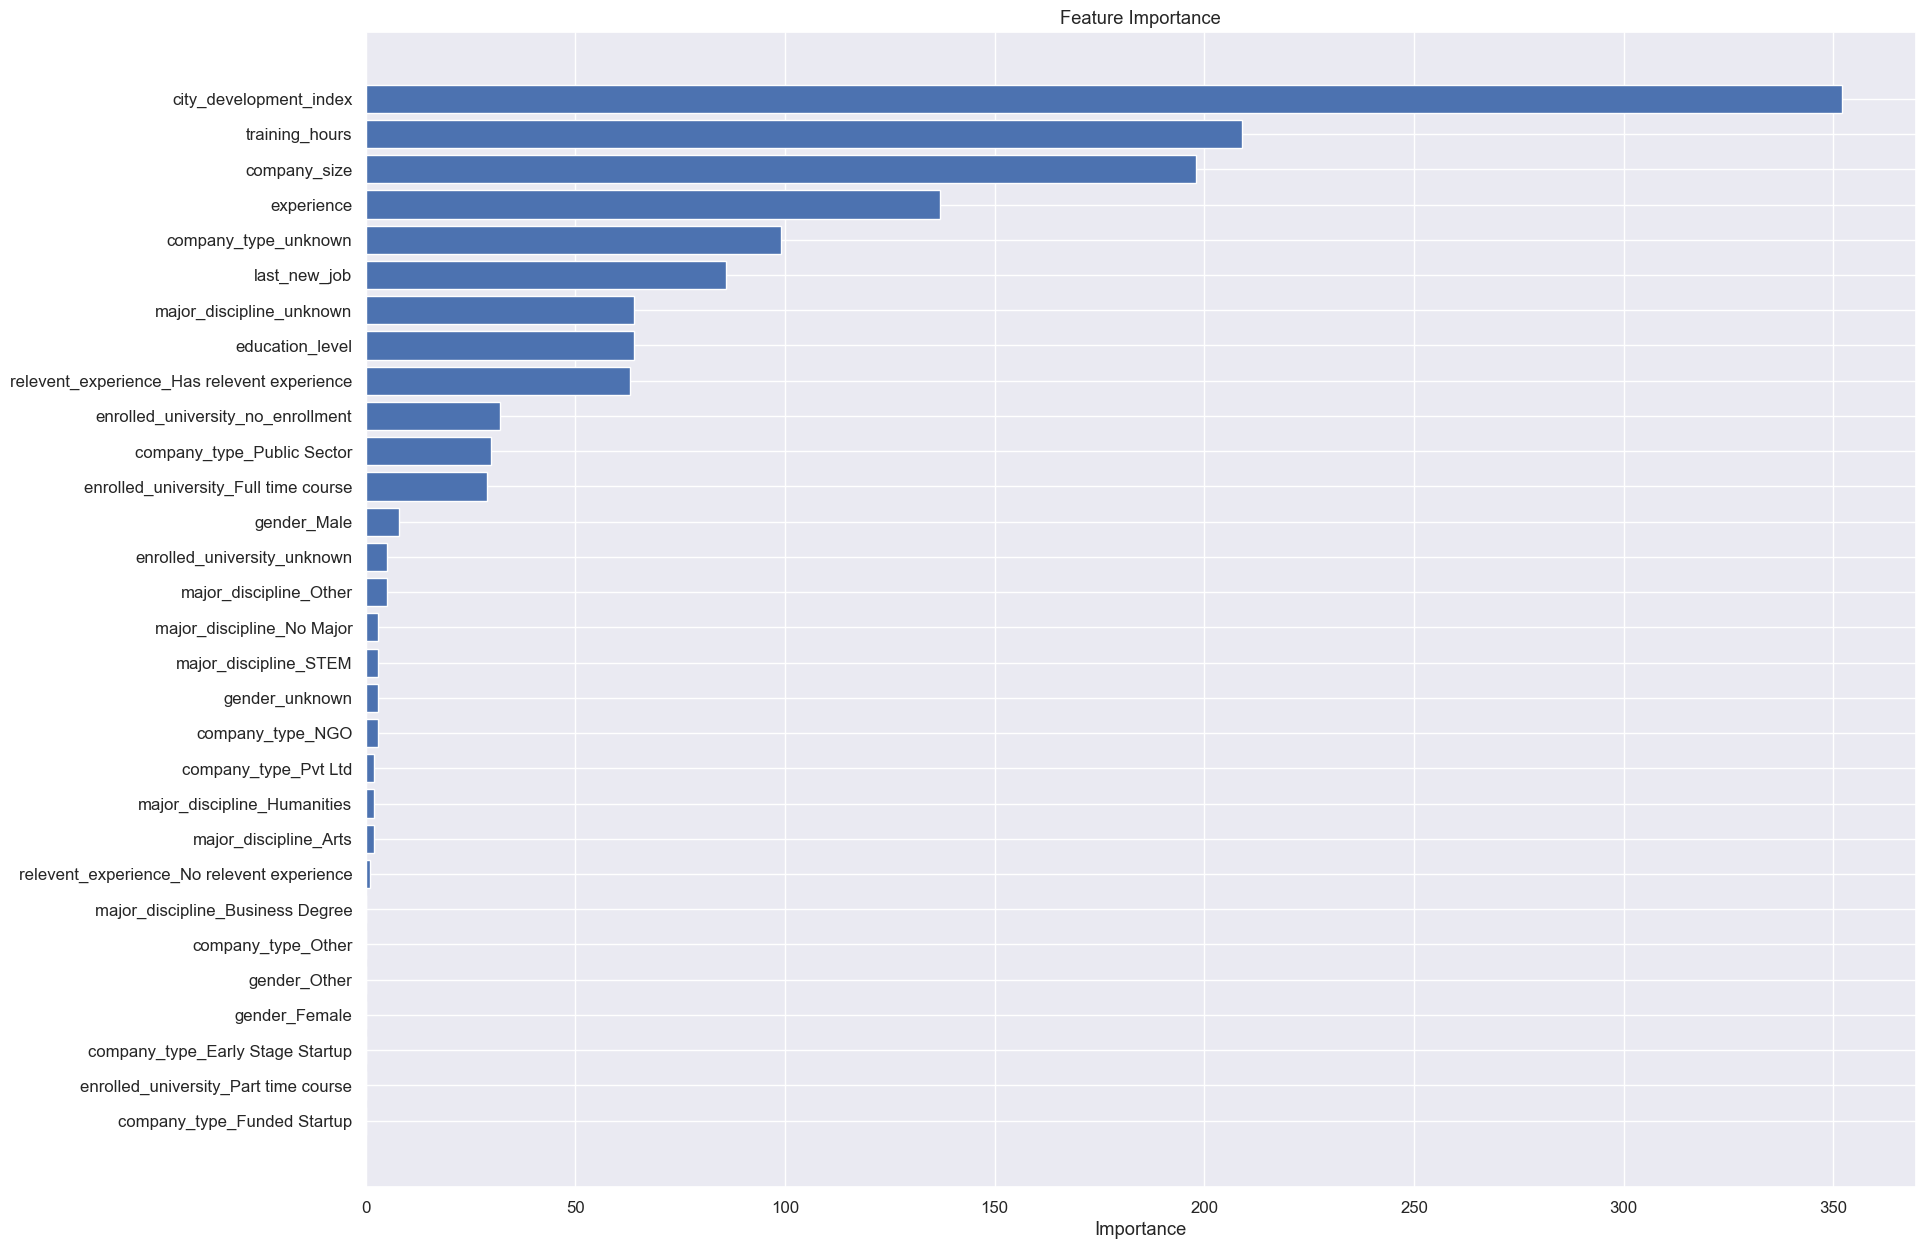

In [77]:
# Access feature importances
importances = grid_lightgmb_halving.best_estimator_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': df_numerical_no_nulls.columns.drop("target"), 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
                                                          
plt.figure(figsize=(20, 15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

As we can see above, the most important feature is: **city_development_index**, its importance doubles the importance for the next feature, which is **training_hours**. This is not suprising at all, because like we saw in the 'seed questions' section, the boxplot of feature city development index is very different for between the two classes.

In the third and fourth position of the most important features we have: the **company size** and the **experience** of the employee.

## Bonus: Pycaret

PyCaret is a Python library for simplified machine learning workflows, offering automated model training, hyperparameter tuning, and comprehensive visualizations. 

In [78]:
# check installed version
import pycaret
pycaret.__version__

'3.2.0'

In [79]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(df_numerical_no_nulls, target = 'target', session_id = 123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(19158, 31)"
4,Transformed data shape,"(19158, 31)"
5,Transformed train set shape,"(13410, 31)"
6,Transformed test set shape,"(5748, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [80]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7891,0.7922,0.5305,0.5859,0.5563,0.4186,0.4197,0.4270
gbc,Gradient Boosting Classifier,0.7861,0.7920,0.4839,0.5862,0.5298,0.3931,0.3963,0.8330
catboost,CatBoost Classifier,0.7861,0.7896,0.4860,0.5863,0.5311,0.3941,0.3973,10.2690
xgboost,Extreme Gradient Boosting,0.7831,0.7810,0.4629,0.5822,0.5154,0.3781,0.3824,0.2490
ada,Ada Boost Classifier,0.7749,0.7883,0.3047,0.5956,0.4025,0.2814,0.3057,0.4110
rf,Random Forest Classifier,0.7748,0.7709,0.4055,0.5680,0.4728,0.3348,0.3426,1.1840
lda,Linear Discriminant Analysis,0.7652,0.7673,0.2976,0.5549,0.3868,0.2579,0.2773,0.0810
ridge,Ridge Classifier,0.7641,0.0000,0.2195,0.5708,0.3166,0.2070,0.2417,0.0550
lr,Logistic Regression,0.7629,0.7685,0.2315,0.5596,0.3272,0.2124,0.2430,1.3180
et,Extra Trees Classifier,0.7589,0.7447,0.3786,0.5233,0.4390,0.2906,0.2969,1.3630


In [81]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [82]:
tuned_best_model = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7882,0.7692,0.5269,0.5828,0.5535,0.4151,0.4160
1,0.8024,0.8256,0.5509,0.6154,0.5814,0.4525,0.4537
2,0.7808,0.7953,0.5240,0.5645,0.5435,0.3995,0.4000
3,0.7927,0.7955,0.5659,0.5870,0.5762,0.4391,0.4392
4,0.7897,0.8014,0.5539,0.5818,0.5675,0.4287,0.4289
5,0.7867,0.7957,0.5359,0.5774,0.5559,0.4158,0.4163
6,0.7815,0.7715,0.5493,0.5644,0.5567,0.4118,0.4119
7,0.8039,0.8091,0.5134,0.6324,0.5667,0.4417,0.4457
8,0.7919,0.7880,0.5075,0.5986,0.5493,0.4152,0.4176


Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Oversampling using SMOTE

As we've done before, we'll try to deal with the imbalanced data using the SMOTE algorith. The pycaret library has this option using the parameter 'fix_imbalance':

In [83]:
s2 = setup(df_numerical_no_nulls, target = 'target', session_id = 124,  fix_imbalance = True)

,Description,Value
0,Session id,124
1,Target,target
2,Target type,Binary
3,Original data shape,"(19158, 31)"
4,Transformed data shape,"(25880, 31)"
5,Transformed train set shape,"(20132, 31)"
6,Transformed test set shape,"(5748, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [84]:
best_smote = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7890,0.7947,0.5583,0.5807,0.5691,0.4295,0.4298,0.8680
catboost,CatBoost Classifier,0.7875,0.7922,0.5416,0.5794,0.5597,0.4199,0.4204,17.5330
gbc,Gradient Boosting Classifier,0.7866,0.7929,0.6151,0.5666,0.5897,0.4459,0.4466,4.5220
xgboost,Extreme Gradient Boosting,0.7781,0.7805,0.4913,0.5633,0.5247,0.3808,0.3825,0.8200
rf,Random Forest Classifier,0.7712,0.7715,0.4426,0.5518,0.4909,0.3457,0.3494,2.4520
ada,Ada Boost Classifier,0.7699,0.7794,0.5245,0.5392,0.5313,0.3790,0.3793,1.2870
et,Extra Trees Classifier,0.7578,0.7512,0.4285,0.5176,0.4687,0.3137,0.3161,2.0300
dummy,Dummy Classifier,0.7506,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1920
ridge,Ridge Classifier,0.7237,0.0000,0.7243,0.4654,0.5665,0.3776,0.3977,0.1720
lda,Linear Discriminant Analysis,0.7235,0.7748,0.7240,0.4652,0.5662,0.3771,0.3972,0.3130


In [85]:
evaluate_model(best_smote)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [86]:
tuned_best_model_smote = tune_model(best_smote)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7711,0.7851,0.5194,0.5438,0.5313,0.3799,0.3801
1,0.7748,0.7808,0.5343,0.5508,0.5424,0.3931,0.3932
2,0.7748,0.7805,0.5134,0.5531,0.5325,0.3844,0.3849
3,0.8091,0.8136,0.6060,0.6208,0.6133,0.4866,0.4866
4,0.7964,0.7891,0.5659,0.5962,0.5806,0.4463,0.4466
5,0.7949,0.7874,0.5659,0.5925,0.5789,0.4434,0.4436
6,0.7919,0.8178,0.5868,0.5816,0.5842,0.4455,0.4455
7,0.8136,0.8272,0.5659,0.6429,0.6019,0.4808,0.4825
8,0.8009,0.8040,0.5838,0.6037,0.5936,0.4618,0.4619


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [87]:
tuned_best_model_smote

LGBMClassifier(bagging_fraction=0.7, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=61, min_child_weight=0.001, min_split_gain=0.2,
               n_estimators=250, n_jobs=-1, num_leaves=10, objective=None,
               random_state=124, reg_alpha=1e-06, reg_lambda=0.5, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# To production

Let's load the model we've created to predict which employees are seeking for a new position and used it with new data to get new and useful insights that we could use to reduce the cost of losing an employee.

First of all, let's load the new data and apply the feature engineering necessary to being able to apply the model we've just created:

In [88]:
df_test = pd.read_csv('aug_test.csv')
df_test.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15


Let's apply the feature engineering:

In [89]:
df_test_numerical = df_test.copy()
df_test_numerical.loc[:,'education_level'] = df_test_numerical['education_level'].map(education_level_map)
df_test_numerical.loc[:,'company_size'] = df_test_numerical['company_size'].map(company_size_map)
df_test_numerical.loc[:,'last_new_job'] = df_test_numerical['last_new_job'].map(last_new_job_map)
df_test_numerical.loc[:,'experience'] = df_test_numerical['experience'].map(experience_map)
df_test_numerical[['gender', 'relevent_experience','enrolled_university','major_discipline','company_type']] = df_test_numerical[['gender', 'relevent_experience','enrolled_university','major_discipline','company_type']].fillna('unknown')
df_test_numerical = pd.get_dummies(df_test_numerical, columns=['gender', 'relevent_experience','enrolled_university','major_discipline','company_type'] )
df_test_numerical.head(3)

,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,gender_Female,gender_Male,...,major_discipline_Other,major_discipline_STEM,major_discipline_unknown,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown
0,32403,city_41,0.827,2.0,9.0,0.0,1.0,21,0,1,...,0,1,0,0,0,0,0,0,0,1
1,9858,city_103,0.920,2.0,5.0,NaN,1.0,98,1,0,...,0,1,0,0,0,0,0,0,1,0
2,31806,city_21,0.624,1.0,0.0,NaN,0.0,15,0,1,...,0,0,1,0,0,0,0,0,1,0


In [90]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
probability_seeking_new_job = loaded_model.predict_proba(df_test_numerical.iloc[:,2:])[:,1]  ## Apply the model to get the probability of each class
prediction_seeking_new_job = loaded_model.predict(df_test_numerical.iloc[:,2:])              ## Apply the model to get the predicted class
df_final_results = df_test.copy()
df_final_results["probability_seeking_new_job"] = probability_seeking_new_job
df_final_results["prediction_seeking_new_job"] = prediction_seeking_new_job
df_final_results.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,probability_seeking_new_job,prediction_seeking_new_job
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21,0.274451,0
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98,0.210618,0
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15,0.809465,1


## Which insights we can get from new data?

### Percentage of employes seeking for a new position

In [91]:
print("Percentage of employees seeking for a new position:\n")
print(100*df_final_results["prediction_seeking_new_job"].sum()/len(df_final_results["prediction_seeking_new_job"]))
print("\n Total of employees seeking for a new position:\n")
print(df_final_results["prediction_seeking_new_job"].sum())

Percentage of employees seeking for a new position:

25.69281352747769

 Total of employees seeking for a new position:

547


The 26.77% of the employes in this new sample are seeking for a new position. Also, this is good news for our model, because this percentage is similar to the same percentage in the training set, so this could indicate that our model generalizes ok!

### Top employers with more probality to being seeking for a new position

In [92]:
df_final_results.sort_values('probability_seeking_new_job', ascending=False)[["enrollee_id","probability_seeking_new_job"]].head(10)

,enrollee_id,probability_seeking_new_job
413,21423,0.809465
101,26180,0.809465
126,24162,0.809465
1613,10478,0.809465
670,20635,0.809465
652,31669,0.809465
650,33343,0.809465
2054,7012,0.809465
1626,18665,0.809465
1890,31758,0.809465


We could send to the HR team a list with the employes with more probability to be seeking a new position in order to able them to take any action to retain these employees.

## Top cities with more employees seeking for a new position

In [93]:
df_final_results[df_final_results.prediction_seeking_new_job == 1].groupby(["city"])["city"].count().sort_values(ascending=False).head(10)

city
city_21     318
city_103     43
city_11      30
city_160     15
city_128     14
city_74      13
city_101     10
city_149      7
city_16       5
city_90       5
Name: city, dtype: int64

The cities above are the 10 top cities with more employees seeking for a new position. It's remarkable the total of employees in the 21st city, because there's a huge difference with the second one city in the list. So it would be interesting to find what's happening to the employees of this city to understand why so many want to search for a new position. Actually, more than a half of the people seeking for a new position is from this city. 

### Share results with the company
An important part of an ML project is being able to make the trained model available for other teams or colleagues of the company to take advantage of the insights they can get of it. One technical way could be creating an API that our colleagues could make their own predictions. Another approach it could be to present the results in an interactive report and enable anyone with the link to get their own insights.

That's why I've created an example of a report that we could create with the results of the model:

In [94]:
from IPython.display import IFrame, HTML
ulr= 'https://lookerstudio.google.com/embed/reporting/195aafd5-d954-44bf-b6bc-ced337f02ece/page/RMGnD'
IFrame(ulr, width='100%', height=500) 